# MLP

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s, in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [3]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words[:]:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return (X, Y)

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

splits = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
}

print(Xtr.shape, Xdev.shape, Xte.shape)

torch.Size([182514, 3]) torch.Size([22904, 3]) torch.Size([22728, 3])


### Initial Loss
Notice that the initial loss (loss at iteration 0) is *very high*, sitting at around $32.0$ (Check MLP-2 to see that this is indeed the case). This tells us that our initialization of weights is incorrect. 
We originally initialize all of the parameters with a normal distribution. However, without any knowledge of what character should come next, the probability distribution of the 27 characters should really be uniform. That is, the logits should be uniformly distributed.
In this case, each character should have a probability 1/27 and hence the initial loss should be close to the following:

In [4]:
-torch.tensor(1/27.0).log().item()

3.295836925506592

Our solution is to make the logits very small such that they are approximately uniform at initialization. Since `logits = h @ W2 @ b2`, we should squash `W2` and `b2`. We do not do anything to `h` for now since `h` is computed at the previous layer.

In [5]:
n_embd = 12
n_hidden = 200

C = torch.randn((27, n_embd))
W1 = torch.randn((n_embd*block_size, n_hidden)) 
#b1 = torch.randn(n_hidden) # bias is not needed for batch norm layer (see section below)                   

W2 = torch.randn((n_hidden, 27)) * 0.01
b2 = torch. randn(27)            * 0

# parameters for batch normilization
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print("number of parameters: ", sum(p.nelement() for p in parameters))

number of parameters:  13351


In [6]:
for p in parameters:
    p.requires_grad = True

In [7]:
print(Xtr.shape)
print(C.shape)
print(W1.shape)

torch.Size([182514, 3])
torch.Size([27, 12])
torch.Size([36, 200])


### Batch Normalization
The process of correctly initalizing the parameters in a layer (discussed below in the **Activation Function** section) takes a lot of statistical considerations and is prone to error, especially in increasingly deep NNs. Introducing a normilization layer after *linear* or *convolutional* layers of a NN provides a simple alternative. 

There are many different types of normalization layers. For our example, we use a **batch normalization** layer which gurantees that a layer is Normally distributed at initialization of the network. (see the **Activation Function** section below to understand why this is important). However, a layer that forces a Gaussian even to the detriment of learning is not ideal, so we introduce `bngain` and `bnbias` to allow the distribution to change in accordance with the training.

Notice that in the batch norm layer, each example, is now a function of every other example in the batch, which happened when subtracted by the mean and divided by the std of that batch. This creates even more entropy which acts as a *regularization* technique in that it prevents overfitting to any one example as now every example is affected by whatever other example happens to be in that batch. Note that this is not always desirable, but is generally useful.

Since the batch norm layer subtracts the mean from each example, the bias is also subtracted in the batch norm layer. This makes sense intuitively as the bias affects all examples and hence the mean is shifted by the bias. So for any layer that preceeds a batch norm, we do not need a bias parameter.

It is not necessary to use a normalization layer after every linear layer, but it is recommended to use one right before the nonlinear layer ($\tanh, \mathrm{relu}$, etc.)

In [8]:
def train(steps=50000):
    eta = 0.1
    max_steps = steps
    for i in range(max_steps):
        #minibatch of 32 inputs
        ix = torch.randint(0, Xtr.shape[0], (32,))
        
        # forward pass
        emb = C[Xtr[ix]] # (len(X), block_size, embed_dim)
        hpreact = emb.view(-1, block_size*n_embd) @ W1 # hidden-layer pre-activation
        
        # batch norm
        # + 0.001 in denominator to prevent division by zero
        hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True) + 0.001) + bnbias
        
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2 # (minibatch_size, 27)
        loss = F.cross_entropy(logits, Ytr[ix]) # -log liklihood
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        #update
        for p in parameters:
            p.data += -eta * p.grad
        if i > 70000:
            eta = 0.01

        # track stats
        if i % 10000 == 0:
            print(f'{i:7d} / {max_steps:7d} : {loss.item():.4f}')

train()

      0 /   50000 : 3.2691
  10000 /   50000 : 2.0642
  20000 /   50000 : 2.5601
  30000 /   50000 : 2.0274
  40000 /   50000 : 1.9046


In [9]:
@ torch.no_grad() # disables gradient tracking for all tensors created in this method -> speeds up training
def split_loss(split):
    x, y = splits[split]
    eta = 0.1
    
    # forward pass
    emb = C[x] # (len(X), block_size, embed_dim)
    hpreact = emb.view(-1, block_size*n_embd) @ W1 # hidden-layer pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True) + 0.001) + bnbias 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (len(X), 27)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


In [10]:
split_loss('train')
split_loss('val')

train 2.2025256156921387
val 2.2149906158447266


---
### Activation Function

Here, we are visualizing the outputs of $\tanh(x)$. Each *row* in the visualization is a sample, and the *columns* correspond
to a neuron in the hidden layer. White indicates that the value of $\tanh$ is $>0.99$,
and thus pushes the *gradients* of the weights that correspond to the neuron towards $0$.
Black indicates values that are $<0.99$ and thus pushes the gradients toward some significant value.
If an entire column is *white* for *all* samples (thought it doesn't seem to be the case from the samples we've tested here), then when we perform matrix multiplication to get the logits, the $27$ weights corresponding
to that neuron will pratically never *converge* because the gradient does not take on a significant value.

A dead neuron can occur due to extremely unlucky initalization.
Another thing that can happen is that during training, the learning rate is set too high and the gradient pushes the values in `C`, `W1`, and `b1` such that the values in a particular row of `emb@W1+b1` are never activated by the $\tanh(x)$ neuron. When this happens, the gradients of the corresponding weights and bias in the hidden layer (stored in `W2` and `b2`) will be approximately $0$ and hence won't learn. The neuron is dead forever.

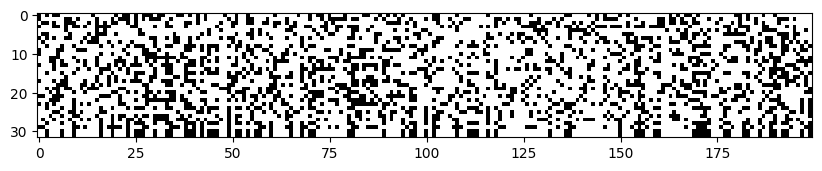

In [11]:
ix = torch.randint(0, Xtr.shape[0], (32,))
emb = C[Xtr[ix]] # (len(X), block_size, embed_dim)
hpreact = emb.view(-1, block_size*n_embd) @ W1 # hidden-layer pre-activation with no batch norm
h = torch.tanh(hpreact) 
plt.figure(figsize=(10,5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

However, every white tile in the diagram above is an inefficiency. Ideally, every value pushes the gradient toward a significant value, so we want a diagram with less white tiles than what we have now. The reason for this problem is because we are using $\tanh(x)$ as the activation function for our hidden layer. Notice that our activation function is taking values from $-20$ to $20$. This is a problem because by the product rule (look at the graph for $\frac{d}{dx}tanh(x)$), the gradient will approach $0$ as the input to $\tanh(x)$ approaches points that are a distance greater than $~2$ from $0$. 

Our current model is actually being bottlenecked by our activation function (or really the range of its inputs) that is essentially deleting any significant changes in our gradients during the backward pass.

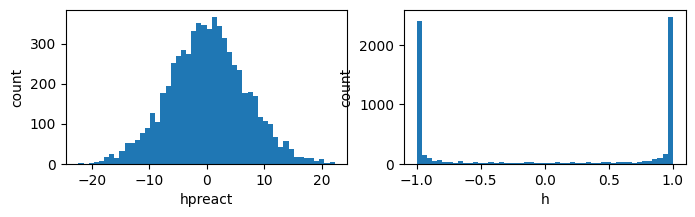

In [12]:
plt.figure(figsize=(8,2))
plt.subplot(121)
plt.xlabel('hpreact')
plt.ylabel('count')
plt.hist(hpreact.view(-1).tolist(), 50);
plt.subplot(122)
plt.ylabel('count')
plt.xlabel('h')
plt.hist(h.view(-1).tolist(), 50); # .view(-1) to flatten the matrix

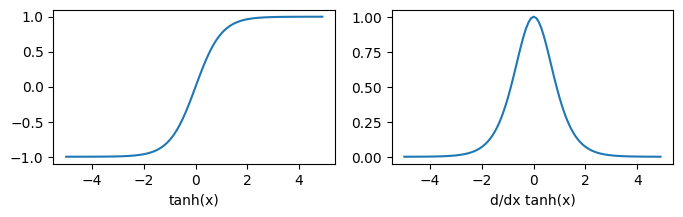

In [13]:
plt.figure(figsize=(8,2))
plt.subplot(121)
plt.plot(np.arange(-5, 5, 0.1), torch.tensor(np.arange(-5, 5, 0.1)).tanh())
plt.xlabel('tanh(x)');
plt.subplot(122)
plt.plot(np.arange(-5, 5, 0.1), torch.tensor(1) - torch.tensor(np.arange(-5, 5, 0.1)).tanh()**2)
plt.xlabel('d/dx tanh(x)');

As seen in the histograms above, the values `hpreact` from the pre-activation layer are too extreme, which causes the outputs of the activation layer ($\tanh$ layer) to be far too saturated in the extremes (which pushes the *gradient* towards zero).
Since `hpreact` depends on `W1` and `b1`, we can squash both matrices to decrease the variance of `hpreact`.

We initialize every parameter with a normal distribution with mean $0$ and std $1$. In the case of $\tanh$, the pre-activation weight is too saturated. We can solve this by multiplying the pre-activation weights by a scalar that will in effect, decrease the std of the pre-activation. In particular the **Kaiming normal** distribution has us scale the weights by 
$$\mathrm{std}=\frac{\mathrm{gain}}{\sqrt{\mathrm{fan_{in}}}}$$
where $\mathrm{fan_{in}}$ (short for *features-in*) is equal to the number of columns (input size) of the weight matrix and $\mathrm{gain}$ is $5/3$ for $\tanh$.
We can just use the utility function `torch.nn.init.kaiming_normal` to do so.

In [14]:
# reinitialize with the squashed parameters
C = torch.randn((27, n_embd))
W1 = torch.randn((n_embd*block_size, n_hidden)) * ((5/3) / (n_embd*block_size)**0.5)
W2 = torch.randn((n_hidden, 27)) * 0.01
b2 = torch. randn(27)            * 0
parameters = [C, W1, W2, b2]
for p in parameters: p.requires_grad = True
train(50000)
ix = torch.randint(0, Xtr.shape[0], (32,))
emb = C[Xtr[ix]] # (len(X), block_size, embed_dim)
hpreact = emb.view(-1, block_size*n_embd) @ W1 # hidden-layer pre-activation
h = torch.tanh(hpreact) 

      0 /   50000 : 3.3425
  10000 /   50000 : 2.2864
  20000 /   50000 : 2.5480
  30000 /   50000 : 2.1319
  40000 /   50000 : 2.3057


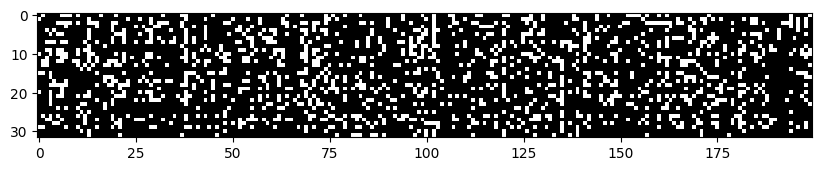

In [15]:
# we can show that batch norm has the same effect.
plt.figure(figsize=(10,5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

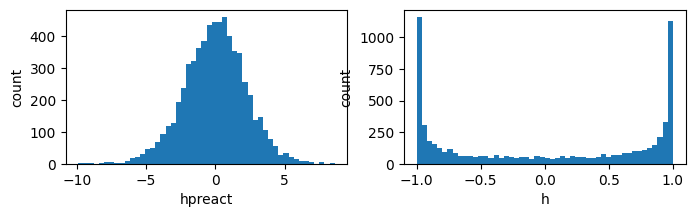

In [16]:
plt.figure(figsize=(8,2))
plt.subplot(121)
plt.xlabel('hpreact')
plt.ylabel('count')
plt.hist(hpreact.view(-1).tolist(), 50);
plt.subplot(122)
plt.ylabel('count')
plt.xlabel('h')
plt.hist(h.view(-1).tolist(), 50); # .view(-1) to flatten the matrix

---
### Sampling

In [17]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [18]:
for _ in range(10):
    name = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (, block_size, d)
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1
        # use mean and std of the entire training dataset for prediction
        hpreact = bngain * (hpreact - bnmean) / (bnstd + 0.001) + bnbias 
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        name.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in name))

mopancidahyiahti.
raq.
ira.
masila.
ykh.
calyn.
crinton.
maiverdyn.
yah.
chusa.
